## This notebook is for creating and testing different models on classifying a salary range for a job posting

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# !jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable widgetsnbextension --user --py --sys-prefix
# Catboost widgets do not seem to work on my vscode notebooks.




The system cannot find the path specified.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
df = pd.read_csv(os.path.dirname(os.getcwd())+"\\EDA\\clean_data.csv").drop(columns=['Unnamed: 0'])
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,data_title,new_title,min_salary,max_salary,loc_state
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K,Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),Data Analyst,Integration Engineer,37,66,NY
1,Quality Data Analyst,$37K-$66K,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),Data Analyst,Quality Analyst,37,66,NY
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K,We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,Data Analyst,Analyst Healthcare,37,66,NY
3,Data Analyst,$37K-$66K,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),Data Analyst,Data Analyst,37,66,NY
4,Reporting Data Analyst,$37K-$66K,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,"New York, NY","New York, NY",501 to 1000 employees,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),Data Analyst,Reporting Analyst,37,66,NY


In [3]:
df.nunique()

Job Title            5338
Salary Estimate       416
Job Description      9683
Rating                 38
Company Name         4521
Location              378
Headquarters          938
Size                    9
Type of ownership      15
Industry               65
Sector                 23
Revenue                14
data_title              4
new_title              72
min_salary            110
max_salary            148
loc_state              16
dtype: int64

In [4]:
cols_to_keep = ['Size','Type of ownership','Industry','Sector','Revenue','data_title','loc_state']
# for now, drop all na values
X = df[cols_to_keep]

y = pd.cut(df["min_salary"],bins=[0,50,75,max(df['min_salary'])],labels=["Under 50k","50-75k","Over 75k"])#,labels=["Low","Average","High"],labels=["Under 50k","50-80k","Over 80k"]
# y = pd.cut(df["max_salary"],bins=[0,90,120,max(df['max_salary'])],labels=["Under 90k","90-120k","Over 120k"])

y.value_counts()

Under 50k    4145
Over 75k     3927
50-75k       3727
Name: min_salary, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True) # Train + val & test

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]
cat_idx = [X.columns.get_loc(col) for col in categorical_features]


# columnTransformer = ColumnTransformer(
#     transformers=[
#         ('cat', OrdinalEncoder(), categorical_features)])

# X_train = columnTransformer.fit_transform(X_train)
# X_test = columnTransformer.fit_transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42,shuffle=True) # Train & val



In [6]:
print("y_train \n",y_train.value_counts()/len(y_train))
print("y_val \n",y_val.value_counts()/len(y_val))
print("y_test \n",y_test.value_counts()/len(y_test))

y_train 
 Under 50k    0.351597
Over 75k     0.330407
50-75k       0.317996
Name: min_salary, dtype: float64
y_val 
 Under 50k    0.352754
Over 75k     0.330862
50-75k       0.316384
Name: min_salary, dtype: float64
y_test 
 Under 50k    0.348729
Over 75k     0.341949
50-75k       0.309322
Name: min_salary, dtype: float64


### Targets have approximately the same distribution

In [7]:
params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 4
}
train_pool = Pool(X_train, y_train, cat_features=cat_idx)
validate_pool = Pool(X_val, y_val, cat_features=cat_idx)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool,plot=True)

print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_test, model.predict(X_test))
))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Simple model validation accuracy: 0.597


### Huge overfitting issue here

### Drop unimportant categories

In [8]:
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

data_title: 69.62601761054266
loc_state: 30.37398238945733
Type of ownership: 0.0
Size: 0.0
Sector: 0.0
Revenue: 0.0
Industry: 0.0


### It is no surprise that the state and the title of the job the minimum salary significantly. Though, what is quite surprising is that the sector and industry do not have any importance in our model. This could be due to missing values, or just due to the datasets underlying structure. I would have quessed that the industry that you are working in would impact on the salary. Either way, lets us drop the features that have no importance at all

In [9]:
params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 10
}
# rm_cols = ['Type of ownership','Sector','Industry']
rm_cols = ['Type of ownership','Industry','Sector','Revenue','Size']
X_train_new = X_train.drop(columns=rm_cols)
X_val_new = X_val.drop(columns=rm_cols)
X_test_new = X_test.drop(columns=rm_cols)

numeric_features = X_train_new.select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in X_train_new.columns if c not in numeric_features]
cat_idx_new = [X_train_new.columns.get_loc(col) for col in categorical_features]

train_pool = Pool(X_train_new, y_train, cat_features=cat_idx_new)
validate_pool = Pool(X_val_new, y_val, cat_features=cat_idx_new)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool,plot=True)

y_pred = model.predict(X_test_new)
print('Simple model test accuracy: {:.4}'.format(
    accuracy_score(y_test, y_pred)
))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Simple model test accuracy: 0.5983


Correct predictions:  59.83 %


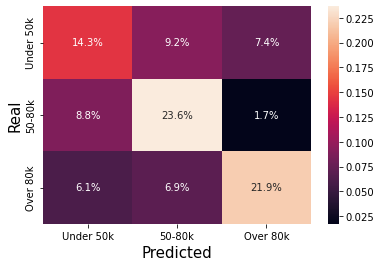

In [10]:
def plot_heatmap(y_true,y_pred):
    conf = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf/len(y_true),annot=True,fmt=".1%",xticklabels=["Under 50k","50-80k","Over 80k"],yticklabels=["Under 50k","50-80k","Over 80k"])
    plt.xlabel('Predicted', fontsize = 15)
    plt.ylabel('Real', fontsize = 15)
    p = np.around(np.sum(np.diag(conf))/len(y_true)*100,2)
    print("Correct predictions: ",p,"%")

plot_heatmap(y_test,y_pred)

In [11]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True) # Train + val & test

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]
cat_idx = [X.columns.get_loc(col) for col in categorical_features]

columnTransformer = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features)])

X_train = columnTransformer.fit_transform(X_train)
X_test = columnTransformer.fit_transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42,shuffle=True) # Train & val

#Create a Gaussian Classifier

clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

Correct predictions:  58.56 %


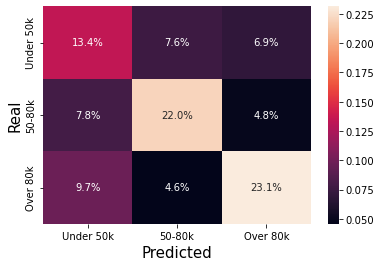

In [12]:
plot_heatmap(y_pred,y_test)

### Seems like the state and data title are hard to use for prediction. There can be different salary ranges within states, but between states for example CA will dominate the salary competition.

<AxesSubplot:xlabel='min_salary', ylabel='Count'>

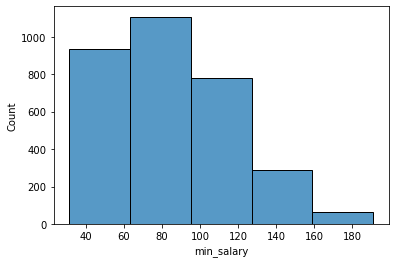

In [13]:
sns.histplot(df[df["loc_state"]=='CA'],x='min_salary',bins=5)

Correct predictions:  51.5 %


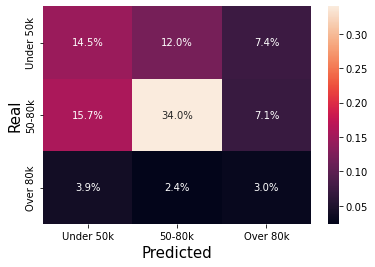

In [14]:
X = df[df["loc_state"]=="CA"]
y = X.pop("min_salary")
cols_to_keep = ['Size','Type of ownership','Industry','Sector','Revenue','data_title']
X = X[cols_to_keep]
y = pd.cut(y,bins=[0,50,80,max(y)],labels=["Under 50k","50-80k","Over 80k"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True) # Train + val & test

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]
cat_idx = [X.columns.get_loc(col) for col in categorical_features]

columnTransformer = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features)])

X_train = columnTransformer.fit_transform(X_train)
X_test = columnTransformer.fit_transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42,shuffle=True) # Train & val

#Create a Gaussian Classifier

clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
plot_heatmap(y_pred,y_test)